In [32]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from dotmap import DotMap

In [4]:
PROJECT_PATH = '../'
DATA_PATH = '/scratch/ceph/swei20/data/ae/dataset/test'
PCA_PATH = '/scratch/ceph/dobos/data/pfsspec/import/stellar/rbf/bosz_5000_full/pca/spectra.h5'
SZALAY_PATH = os.path.join("/scratch/ceph/szalay/swei20/AE", 'pca.h5')
sys.path.insert(0, PROJECT_PATH)

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [6]:
import tensorflow as tf
# tf.enable_v2_behavior()
gpus = tf.config.list_physical_devices('GPU') 
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Loading Data

In [7]:
with h5py.File(PCA_PATH, 'r') as f:
#     flux = f['flux'][()]
#     flux_idx = f['flux_idx'][()]
#     Fe_H = f['Fe_H'][()]
#     log_g = f['log_g'][()]
#     O_M = f['O_M'][()]
#     C_M = f['C_M'][()]
#     T_eff = f['T_eff'][()]
    wave = f['wave'][()]
#     eigv = f['flux_eigv'][()]


In [906]:
with h5py.File(SZALAY_PATH, 'w') as f:
    f.create_dataset('flux', data = flux_clean, shape = (116614, 1000))
    f.create_dataset('eigv', data = eigv, shape = (15404, 1000))    
    f.create_dataset('Fe_H', data = Fe_Hs, shape = (116614,))    
    f.create_dataset('T_eff', data = T_effs, shape = (116614,))    
    f.create_dataset('log_g', data = loggs, shape = (116614,))    
    f.create_dataset('C_M', data = CMs, shape = (116614,))    
    f.create_dataset('O_M', data = OMs, shape = (116614,))    

In [8]:
with h5py.File(SZALAY_PATH, 'r') as f:
    flux = f['flux'][()]
    eigv = f['eigv'][()]

In [9]:
flux.shape

(116614, 1000)

In [869]:
def prepro_pca(flux, dim=300):
    flux0 = flux.reshape(-1, 1000)[:, :dim]    
    clean_idx = np.isnan(flux0[:,0])
    flux_clean = flux0[~clean_idx]    
    print(flux_clean.shape, flux0.shape)
    print('min', flux_clean.min(), 'max', flux_clean.max(),'mean', flux_clean.mean(),'std', flux_clean.std() )
    return flux_clean, clean_idx

In [870]:
flux1, clean_idx = prepro_pca(flux, dim=300)

(116614, 300) (243936, 300)
min -184.9254058126797 max 145.24091665337806 mean -0.10353327716635463 std 2.4000601615265493


In [10]:
flux32 = flux[:, :32]

In [13]:
flux32.min(), flux32.max(), flux32.mean(), flux32.std()

(-184.9254058126797,
 145.24091665337806,
 -0.9705922500630375,
 7.284266458811254)

In [97]:
flux32_mean = flux32.mean(0)

In [98]:
flux32_mean.shape

(32,)

In [99]:
flux32m = flux32 - flux32_mean

In [106]:
flux32ms = flux32m / flux32m.std()

In [108]:
SAVE_PATH = "/home/swei20/AE/data/pc32.h5"

In [109]:
with h5py.File(SAVE_PATH, 'a') as f:
    f.create_dataset('flux32m', data = flux32m)
    f.create_dataset('flux32ms', data = flux32ms)    

In [8]:
flux32.shape

(116614, 32)

# Scaled RMS
AFTER 50 EPOCHS
input_dim=300, latent_dim=32, hidden_dims=[256, 128], dropout=0.0, lr=0.003, reg1=1e-06, loss='mae', opt='adam', batchnorm=0
epoch=50, batch_size=16, validation_split=0.3, verbose=0
mae_lr2_l32_h256_h128_INleEMleHDle_t_act_0702_120042

### 0.0 NO SCALING (BEST):
     ACC 95.9% | VACC 89.04%

### 0.1:
    ACC 95.73% | VACC 83.54%
    
### 0.3:
    ACC 94.49% | VACC 77.52%
  
### 2/3 (0.66):
    ACC 90.14% | VACC 63.06%
Epoch 5/5
5102/5102 [==============================] - 12s 2ms/step - loss: 0.0949 - acc: 0.8623 - val_loss: 0.3018 - val_acc: 0.6527

### 0.8:
Epoch 5/5
5102/5102 [==============================] - 12s 2ms/step - loss: 0.1369 - acc: 0.7936 - val_loss: 0.4246 - val_acc: 0.4212



In [62]:
std32 = np.std(flux32, axis= 0)

In [ ]:
mean32 = np.mean

In [ ]:
flux32norm = flux32 - 

In [63]:
std32.shape

(32,)

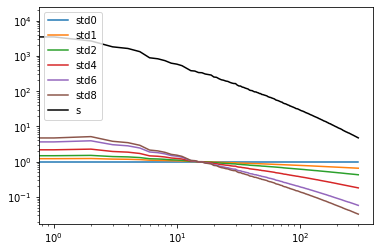

In [663]:
for rate in [0.0, 0.1, 0.2, 0.4, 2/3, 0.8]:
    name = str(rate)[-1]
    plt.plot(std300**rate, label=f'std{name}')

plt.plot(s[:300]**0.5,label='s', color='k')
plt.yscale('log')
plt.xscale('log')
plt.legend()

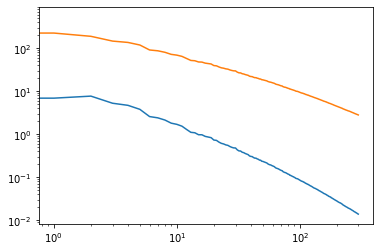

In [616]:
plt.plot(std300)
plt.plot(s[:300]**0.333)
plt.yscale('log')
plt.xscale('log')

In [608]:
flux_std.shape

(116614, 300)

## AE

In [787]:
from ae.pipeline.simple_ae_pipeline import SimpleAEPipeline

In [788]:
sp=SimpleAEPipeline()

In [669]:
config_dict ={
    "data": {
      "dir":"./data",
      "filename": "pca.h5",
      "train": "flux",
      "std_rate": 0.0
    },
    "model":{
      "aug": 1,
      "name": "t_act_",
      "input_dim": 300,
      "latent_dim": 32,
      "hidden_dims": [256, 128],
      "dropout": 0.0,
      "lr": 0.003,
      "reg1": 0.000001,
      "loss": "mae",
      "opt": "adam",
      "batchnorm": 0,
      "act_in": "leaky",
      "act_em": "leaky",
      "act_hd": "leaky"
    },
    "trainer":{
      "epoch": 20,
      "batch_size": 16,
      "validation_split":0.3,
      "verbose": 1
    },
    "callbacks":{
        "checkpoint_monitor": "val_loss",
        "checkpoint_mode": "min"
    }
}
config = DotMap(config_dict)

In [670]:
from ae.model.simple_ae_model import SimpleAEModel
from ae.trainer.simple_ae_trainer import SimpleAETrainer

In [671]:
mm = SimpleAEModel()
mm.build_model(config)

INFO:root:Layers: [300, 256, 128, 32]
INFO:root:NAME: mae_lr2_l32_h256_h128_INleEMleHDle_t_act_0702_123331


In [672]:
data = x_train
tt = SimpleAETrainer(mm, config)
history = tt.train((data, data), ep=20)

Epoch 1/20
5102/5102 [==============================] - 17s 3ms/step - loss: 0.0630 - acc: 0.8490 - val_loss: 0.1294 - val_acc: 0.8484
Epoch 2/20
5102/5102 [==============================] - 16s 3ms/step - loss: 0.0433 - acc: 0.9183 - val_loss: 0.1105 - val_acc: 0.8462
Epoch 3/20
5102/5102 [==============================] - 16s 3ms/step - loss: 0.0394 - acc: 0.9282 - val_loss: 0.1098 - val_acc: 0.8458
Epoch 4/20
5102/5102 [==============================] - 16s 3ms/step - loss: 0.0371 - acc: 0.9308 - val_loss: 0.1084 - val_acc: 0.8752
Epoch 5/20
5102/5102 [==============================] - 16s 3ms/step - loss: 0.0356 - acc: 0.9356 - val_loss: 0.1079 - val_acc: 0.8474
Epoch 6/20
5102/5102 [==============================] - 15s 3ms/step - loss: 0.0347 - acc: 0.9384 - val_loss: 0.1025 - val_acc: 0.8494
Epoch 7/20
5102/5102 [==============================] - 15s 3ms/step - loss: 0.0338 - acc: 0.9388 - val_loss: 0.1032 - val_acc: 0.8675
Epoch 8/20
5102/5102 [==============================] -

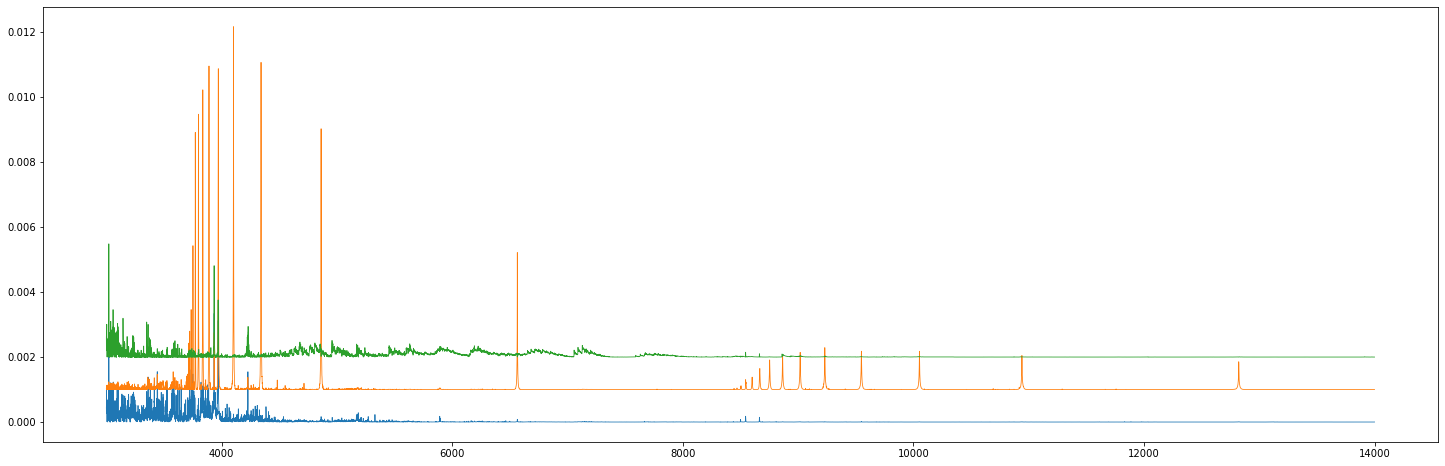

In [706]:
f, ax = plt.subplots(figsize=(25, 8))
shift = [0, 0.001, 0.002]
for i, k in enumerate([0,1,2]):
    ax.plot(wave,(eigv300**2)[:,k] + shift[i], lw=0.8)

[]

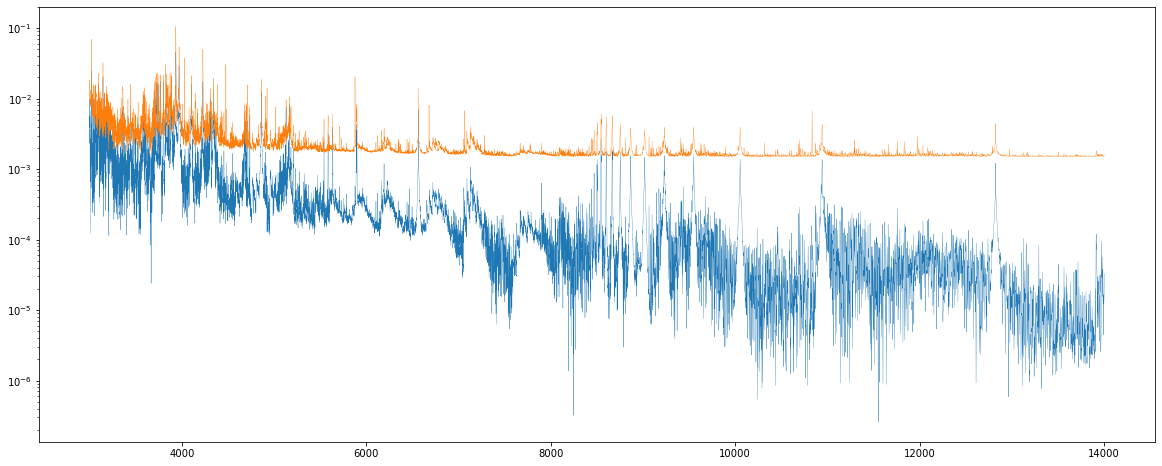

In [696]:
f, ax = plt.subplots(figsize=(20, 8))
ii = [0, 0.001]
for i, k in enumerate([10,20]):
    ax.plot(wave, U[:, k] + ii[i], lw=0.3)
ax.semilogy()

In [ ]:
f, ax = plt.subplots(figsize=(8, 5))
for k in [10,20,30,50,100]:
    ax.plot(wave, U[:, k], lw=0.3)
ax.semilogy()

In [810]:
mm.input_dim

32

In [812]:
data

(array([[-30.33843814,   2.19566251,  -5.00169231, ...,   0.08428099,
          -0.75231602,  -0.37860026],
        [-32.76465679,   2.28111448,  -5.43600953, ...,   0.27198981,
          -0.6036088 ,  -0.34214707],
        [-35.87035936,   2.47461485,  -5.92581658, ...,   0.42766352,
          -0.42159495,  -0.346206  ],
        ...,
        [ -3.61853188,  -4.96887113,   1.29046512, ...,   0.2662947 ,
           0.29613001,  -0.05001908],
        [ -3.83585953,  -4.97308565,   1.35623181, ...,   0.32270847,
           0.31829991,  -0.09614977],
        [ -4.1188783 ,  -4.98053168,   1.44475424, ...,   0.38930538,
           0.3333085 ,  -0.14854535]]),
 array([[-30.33843814,   2.19566251,  -5.00169231, ...,   0.08428099,
          -0.75231602,  -0.37860026],
        [-32.76465679,   2.28111448,  -5.43600953, ...,   0.27198981,
          -0.6036088 ,  -0.34214707],
        [-35.87035936,   2.47461485,  -5.92581658, ...,   0.42766352,
          -0.42159495,  -0.346206  ],
        ...,


In [ ]:
def get_analysis(mm, full_eigv, data):
    eigv = full_eigv[:, :mm.input_dim]    
    ae_pred = mm.model.predict(data[0])
    flux_org = data[0].dot(eigv.T)
    flux_rec = ae_pred.dot(eigv.T)
    e = Eval(wave, flux_org, flux_rec, err=err)    
    return ae_pred, flux_org, flux_rec, ae_pred

In [594]:
err= np.abs(flux_org -flux_rec)

In [595]:
np.mean(np.sum(err, axis=1))

108.08298797191254

In [41]:
class Eval(object):
    def __init__(self, wave, org, rec, err=None):
        self.org=org
        self.rec=rec
        self.wave=wave
        self.abs_err= err
    
    def get_abs_err(self):
        return abs(self.org - self.rec)
    
    def plot_flux(self, idx, ax=None):
        ax = ax or plt.gca()
        ax.plot(self.wave, self.org[idx], c='k', label='pca')
        ax.plot(self.wave, self.rec[idx], alpha=0.5, c='r', label='rec')
        ax.set_xlim(self.wave[0], self.wave[-1])
        ax.legend(loc=4)
        
    def plot_err(self, idx, ax=None):
        ax = ax or plt.gca()
        ax.plot(self.wave, self.abs_err[idx], c='k', label='abs_err')
        ax.set_xlim(self.wave[0], self.wave[-1])
        ax.legend(loc=1)
        
    def plot_all(self, idx):
        f, axs = plt.subplots(2,1, figsize=(20,10), sharex="all")
        self.plot_flux(idx, ax=axs[1])
        self.plot_err(idx, ax=axs[0])
        

In [568]:
err= np.abs(flux_org -flux_rec)

In [601]:
e = Eval(wave, flux_org, flux_rec, err=err)

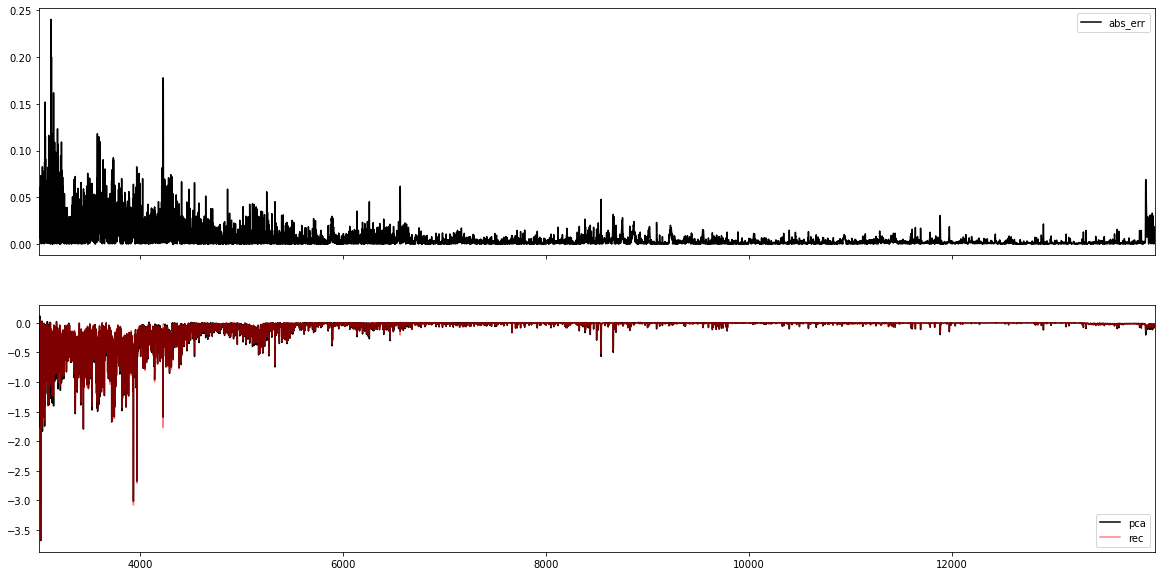

In [602]:
e.plot_all(0)

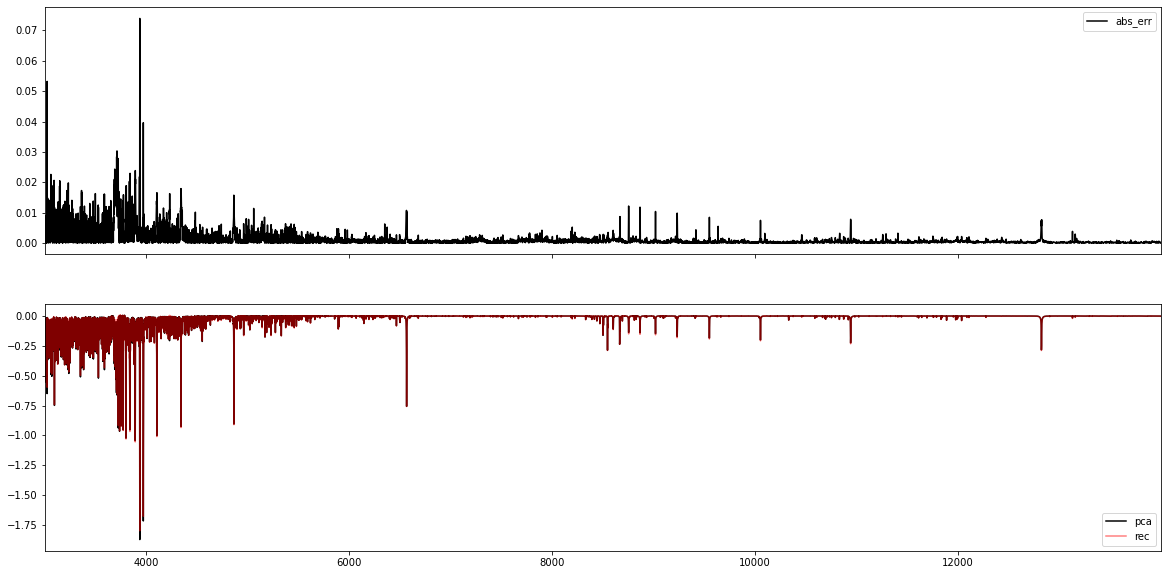

In [603]:
e.plot_all(10000)

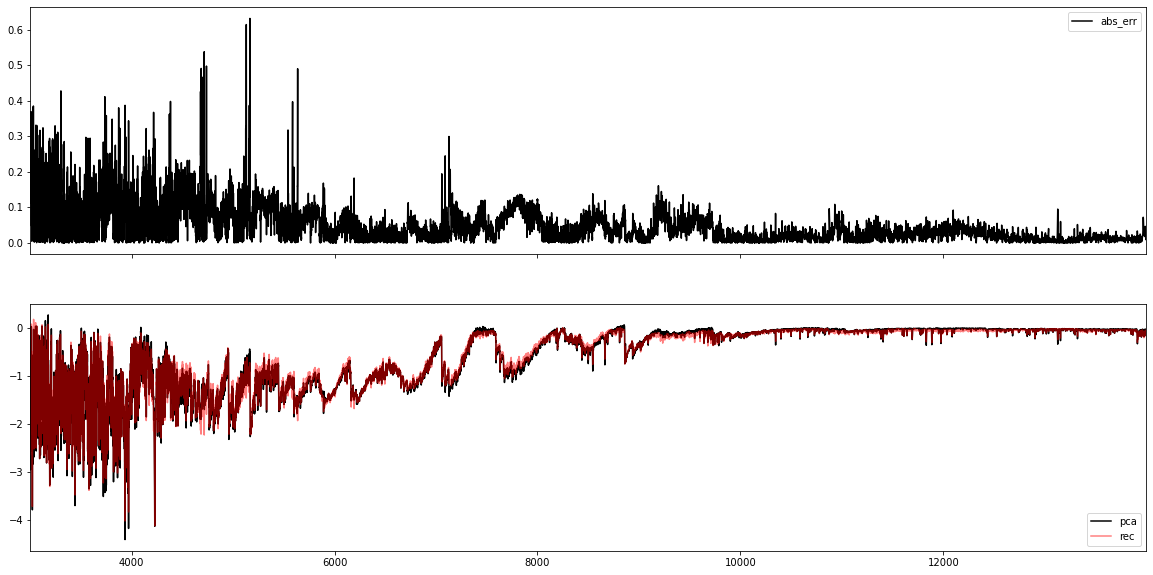

In [604]:
e.plot_all(100000)

In [ ]:
idx = 0
f, axs = plt.subplots(2,1, figsize(30,20))

axs.plot(wave, flux_org[0], 'k')
plt.plot(wave, flux_rec[0], alpha=0.5, c='r')

In [ ]:
def plot_flux(flu)

[[<matplotlib.lines.Line2D at 0x7f7a60f77bb0>],

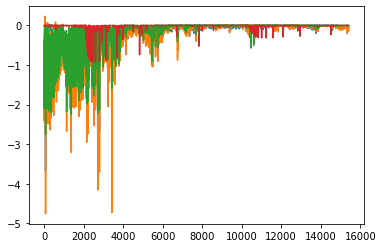

In [504]:
[plt.plot(wave, flux_org[i]) for i in [0,100,1000,40000]]

[[<matplotlib.lines.Line2D at 0x7f7a60f13550>],

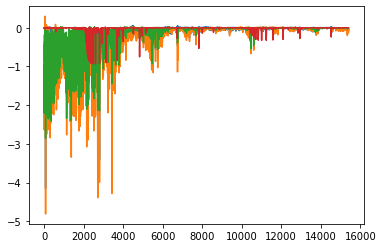

In [507]:
[plt.plot(flux_rec[i]) for i in [0,100,1000,40000]]

# 1. Verify MSE

### A. On small random matrix

In [718]:
from scipy.stats import ortho_group

In [740]:
rand_mat = np.random.random(size=(7, 4))
psi, _ = np.linalg.qr(rand_mat)
np.sum(psi**2, 0), psi.shape

(array([1., 1., 1., 1.]), (7, 4))

In [747]:
aa = np.array([[1,2,3,4]])
bb = np.array([[1.2,1.8, 2.5,4.1]])
np.sum((aa - bb)**2)
# bb = np.array([[1.2,1.8, 2.5,4.1,5.1 ,5.9, 6.8]])

0.3399999999999999

In [752]:
saa = aa.dot(psi.T)
sbb = bb.dot(psi.T)
np.sum((saa - sbb)**2), saa.shape,

(0.3399999999999995, (1, 7))

### B. On specs

In [755]:
def get_mse(org, rec):
    diff = np.sum((org - rec)**2 , 1)
    mse = np.mean(diff)
    print(org.shape, rec.shape, diff.shape, mse)

In [841]:
# get_mse(x_train[0], ae_pred[0])

In [757]:
flux_org = x_train.dot(eigv300.T)
flux_rec = ae_pred.dot(eigv300.T)

In [758]:
get_mse(flux_org, flux_rec)

(116614, 15404) (116614, 15404) (116614,) 18.589451421547327


# 2. Lick indices

In [66]:
plt.style.use('ieee')

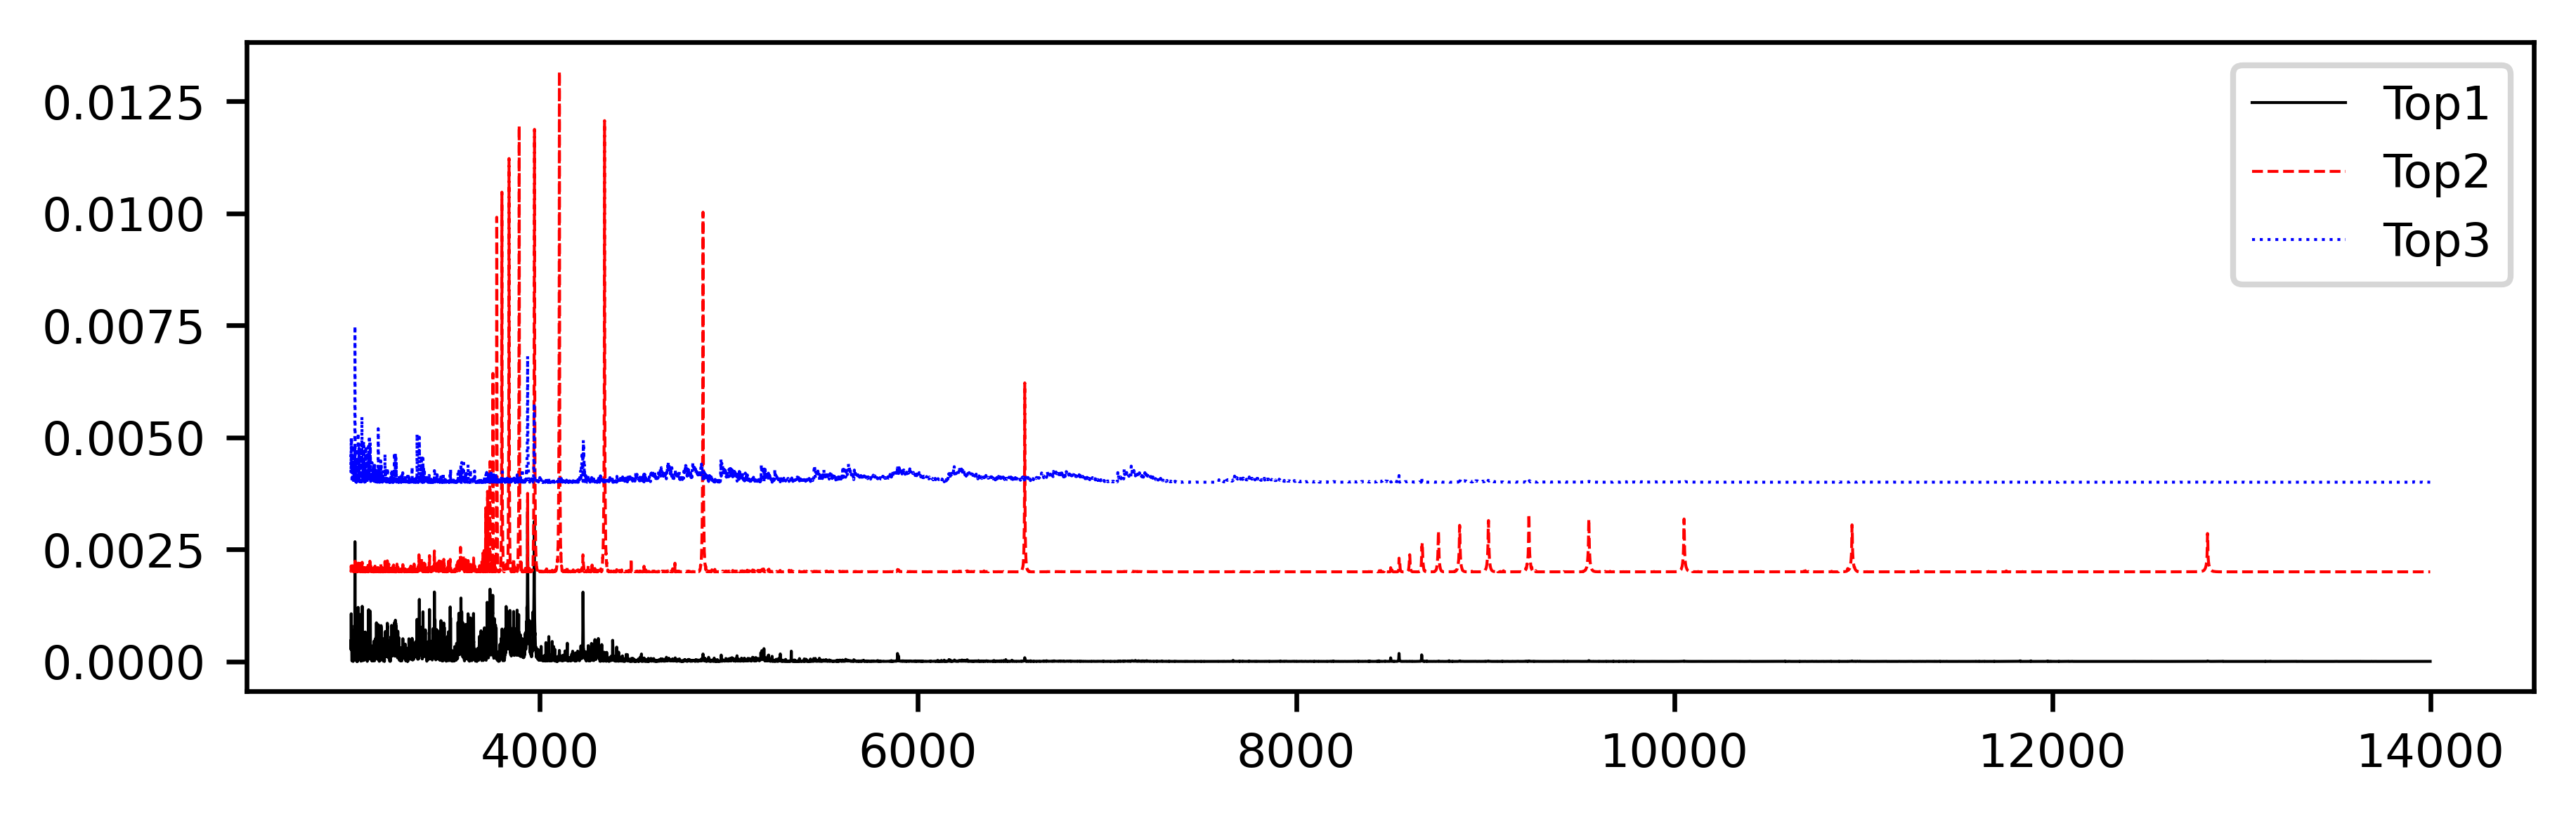

In [87]:
f, ax = plt.subplots(figsize=(7, 2))
shift = [0, 0.002, 0.004]
for i, k in enumerate([0,1,2]):
    ax.plot(wave,(eigv**2)[:,k] + shift[i], lw=0.5, label = f"Top{k+1}")
ax.legend()

### Line Spectrum
 - 1st: Eigenvector describe UV part of the spectrum
 - 2nd: starts to add up balmer and paschen series 
 - 3rd: broader lines
 - biggest changes among the spectra
 - Different eigenvectors contain quiet different infomation
 
 Find out which ones correlate with [Fe/H], T_eff
 Start adding vecs up, and see which
 
 What is the amplitude of balmer series
 
 how different look in parameter space
 

In [16]:
config_dict = {"data": {
      "dir":"../data",
      "filename": "pc32.h5",
      "train": "flux"
    },
    "model":{
      "aug": 1,
      "name": "pc32_",
      "input_dim": 32,
      "latent_dim": 8,
      "hidden_dims": [128, 64],
      "dropout": 0.0,
      "lr": 0.003,
      "reg1": 0.0001,
      "loss": "mse",
      "opt": "adam",
      "batchnorm": 0,
      "act_in": "leaky",
      "act_em": "leaky",
      "act_hd": "leaky"
    },
    "trainer":{
      "epoch": 50,
      "batch_size": 16,
      "validation_split":0.3,
      "verbose": 1
    },
    "callbacks":{
        "checkpoint_monitor": "val_loss",
        "checkpoint_mode": "min"
    }
}
config = DotMap(config_dict)

In [34]:
from ae.data_loader.pc_data_loader import PcDataLoader
from ae.model.simple_ae_model import SimpleAEModel
from ae.trainer.simple_ae_trainer import SimpleAETrainer

In [848]:
ds = PcDataLoader()
ds.init_from_config(config)
data = ds.get_train_data()

In [18]:
mm = SimpleAEModel()
mm.build_model(config)

In [855]:
mm.load("/home/swei20/AE/trained_model/ep50_mse_lr2_32_l12_h128_h64_INleEMleHDle_pc32_0703_211813/")

Loading model checkpoint /home/swei20/AE/trained_model/ep50_mse_lr2_32_l12_h128_h64_INleEMleHDle_pc32_0703_211813/ ...

Model loaded


In [19]:
checkpoint_path = "/home/swei20/AE/trained_model/ep500_mse_lr2_32_l8_h128_h64_INleEMleHDle_pc32_0703_212611/"
mm.load(checkpoint_path)

Loading model checkpoint /home/swei20/AE/trained_model/ep500_mse_lr2_32_l8_h128_h64_INleEMleHDle_pc32_0703_212611/ ...

Model loaded


In [35]:
tt = SimpleAETrainer(mm, config)

In [36]:
data =(flux32,flux32)
history = tt.train(data, ep=1)

5102/5102 [==============================] - 17s 3ms/step - loss: 0.0271 - mean_squared_error: 0.0089 - val_loss: 0.2987 - val_mean_squared_error: 0.2804


In [37]:
tt.eval(eigv)

NameError: name 'eigv' is not defined

In [38]:
def get_analysis(mm, full_eigv, x_train):
    eigv = full_eigv[:, :mm.input_dim]    
    ae_pred = mm.model.predict(x_train)
    flux_org = x_train.dot(eigv.T)
    flux_rec = ae_pred.dot(eigv.T)
    return ae_pred, flux_org, flux_rec, eigv


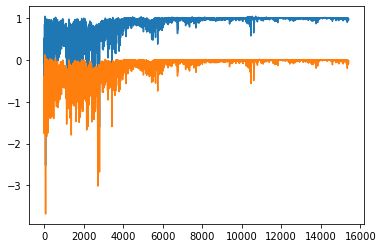

In [832]:
plt.plot(flux_org32[0]+ 1)
plt.plot(flux_org[0])

In [39]:
ae_pred32, flux_org32, flux_rec32, eigv32 = get_analysis(mm, eigv, flux32)

In [42]:
err32 = abs(flux_org32 - flux_rec32)
e32 = Eval(wave, flux_org32, flux_rec32, err=err32)

In [822]:
e = Eval(wave, flux_org, flux_rec, err=err)

In [44]:
plt.style.use('default')

In [47]:
flux32[0]

array([-30.33843814,   2.19566251,  -5.00169231,   0.45519214,
         3.19750438,  -3.21419894,  -0.88928209,   0.15140914,
        -2.7110318 ,   0.34404636,   1.03383906,  -1.94391769,
        -0.07943541,   1.73540708,   1.73591179,   0.36524992,
        -2.35718457,   0.94743202,  -0.70152524,   0.58389272,
         2.07022659,  -1.48307841,  -1.57718067,  -0.28932175,
        -0.85833711,  -1.87435561,  -0.12659036,   0.45004409,
         0.61617448,   0.08428099,  -0.75231602,  -0.37860026])

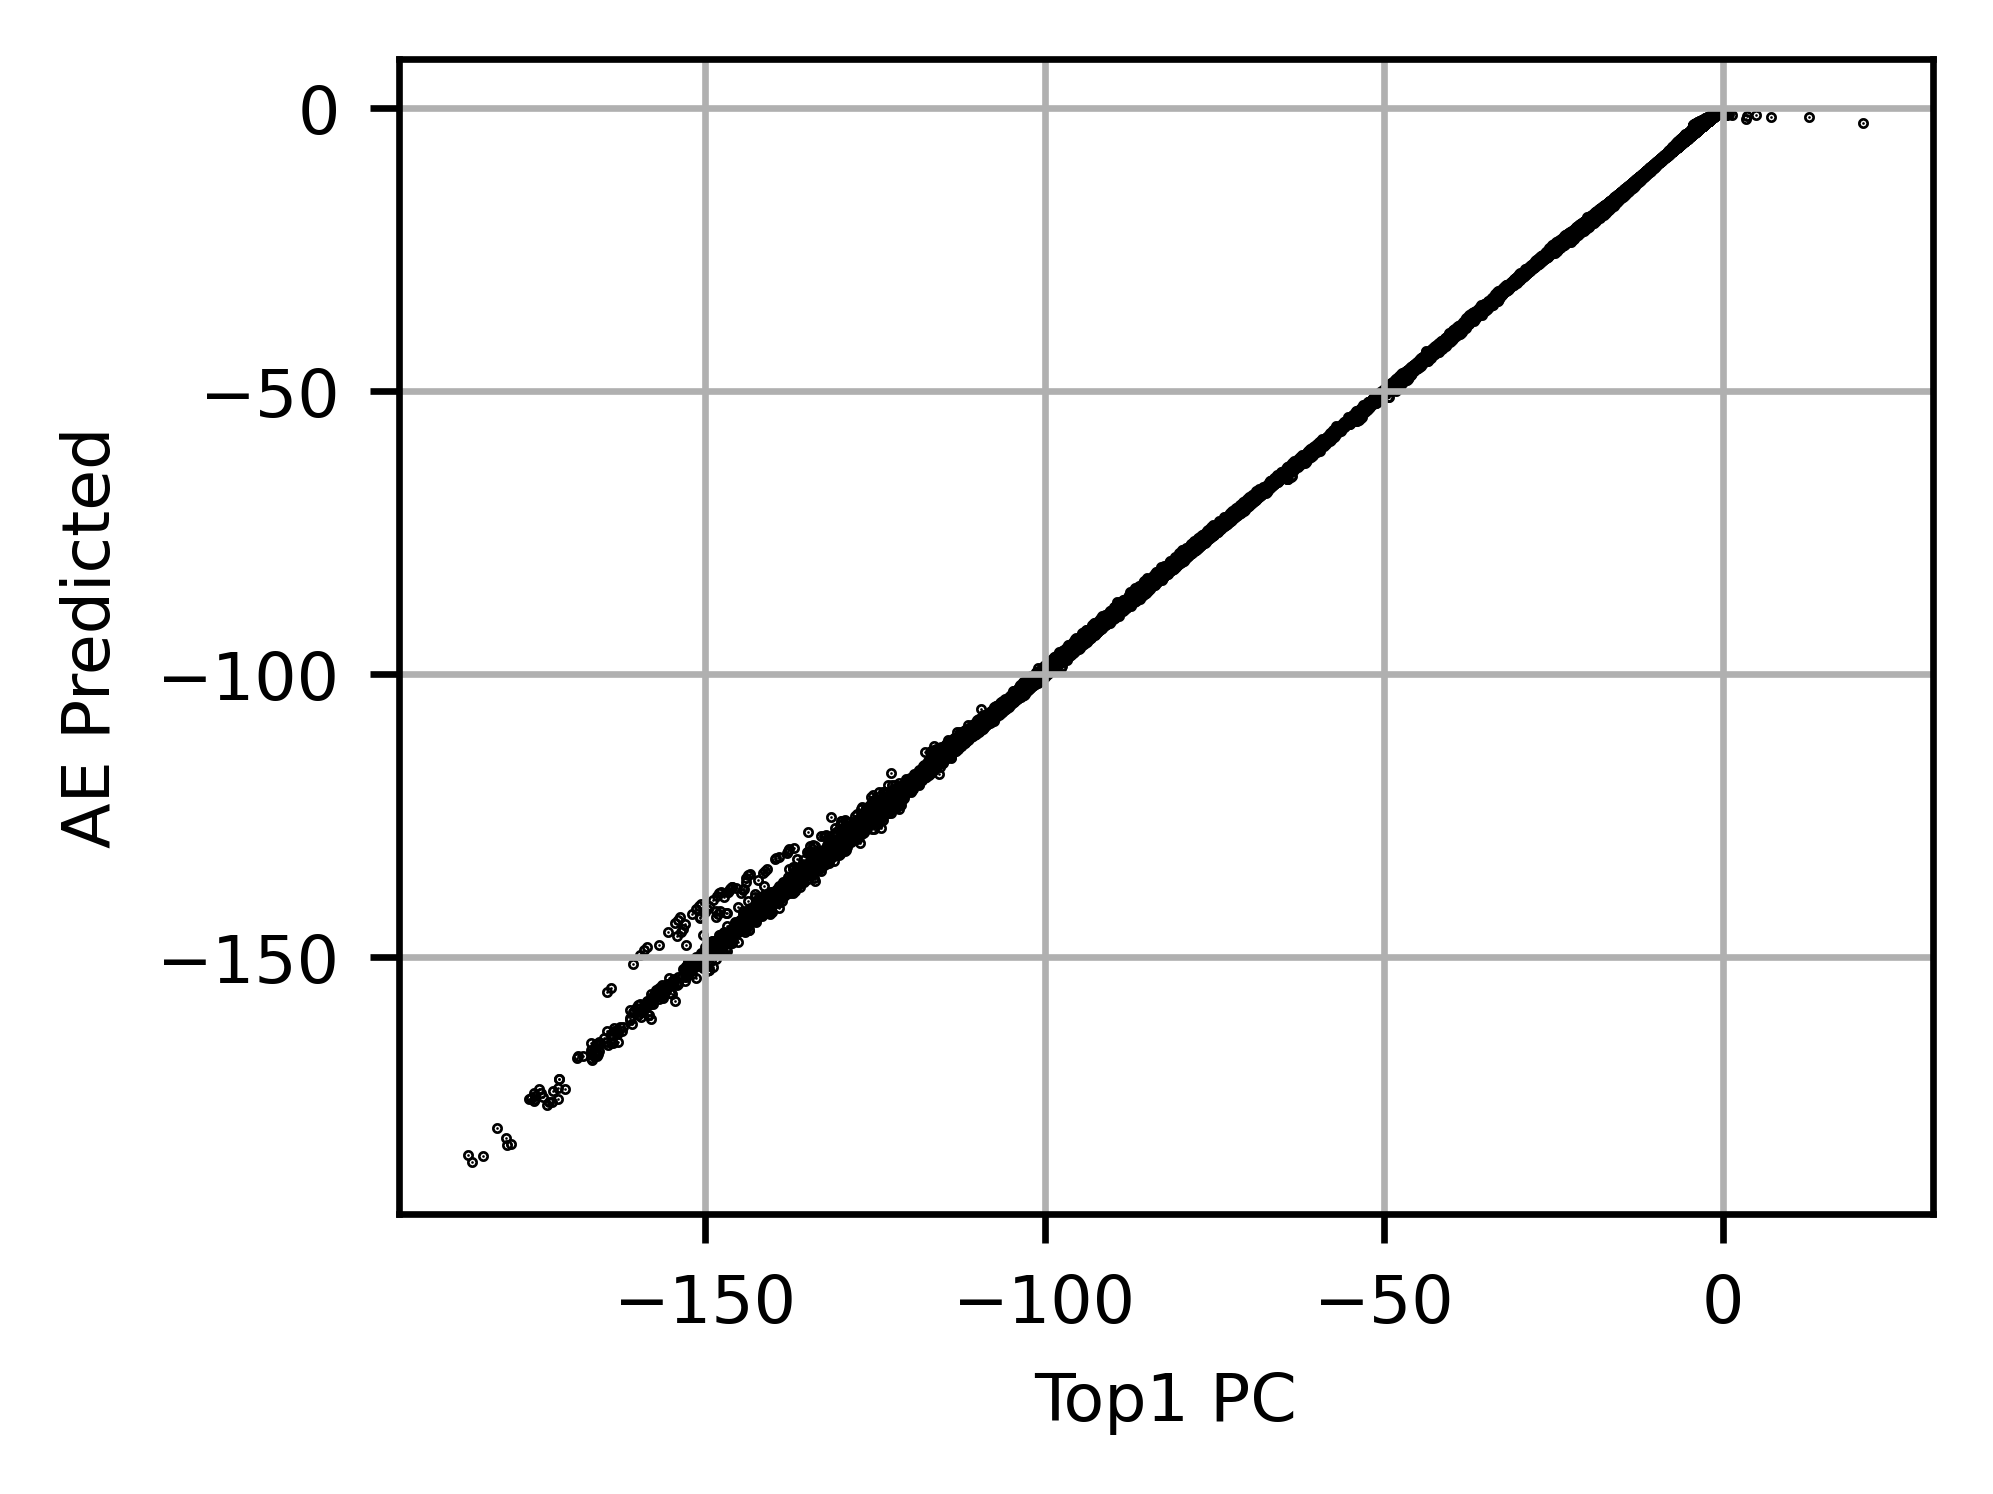

In [86]:
idx=0
plt.scatter(flux32[:, idx],ae_pred32[:, idx], s=0.1)
# plt.plot(   s=0.1, c='k')
plt.xlabel(f"Top{idx+1} PC")
plt.ylabel("AE Predicted")

# plt.legend()
plt.grid(1)

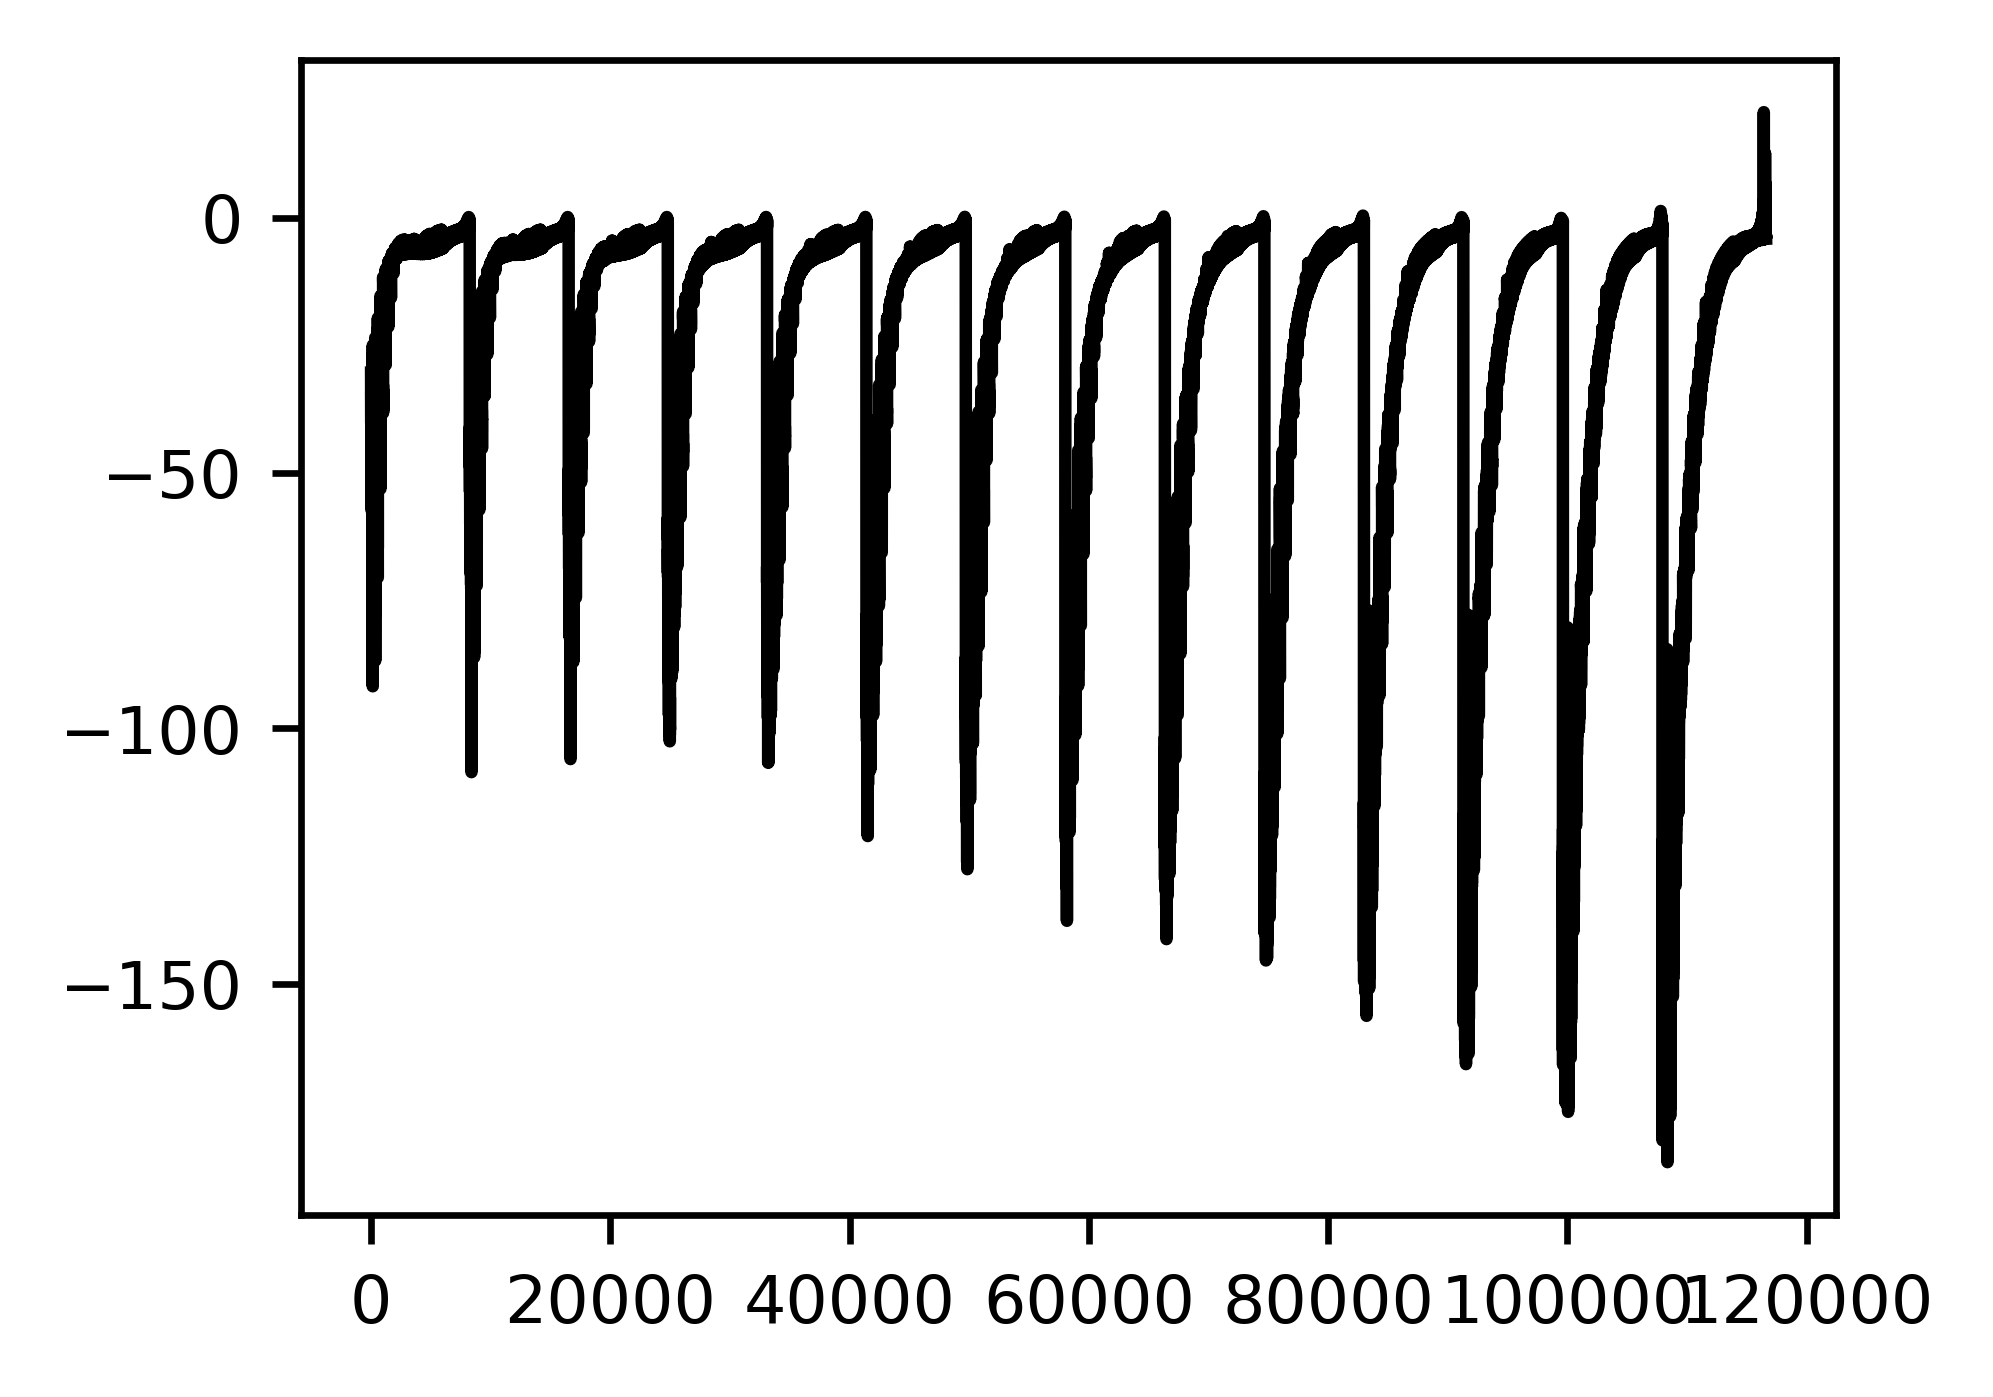

In [96]:
plt.plot(flux32[:, 0])

(-5.0, 1.0)

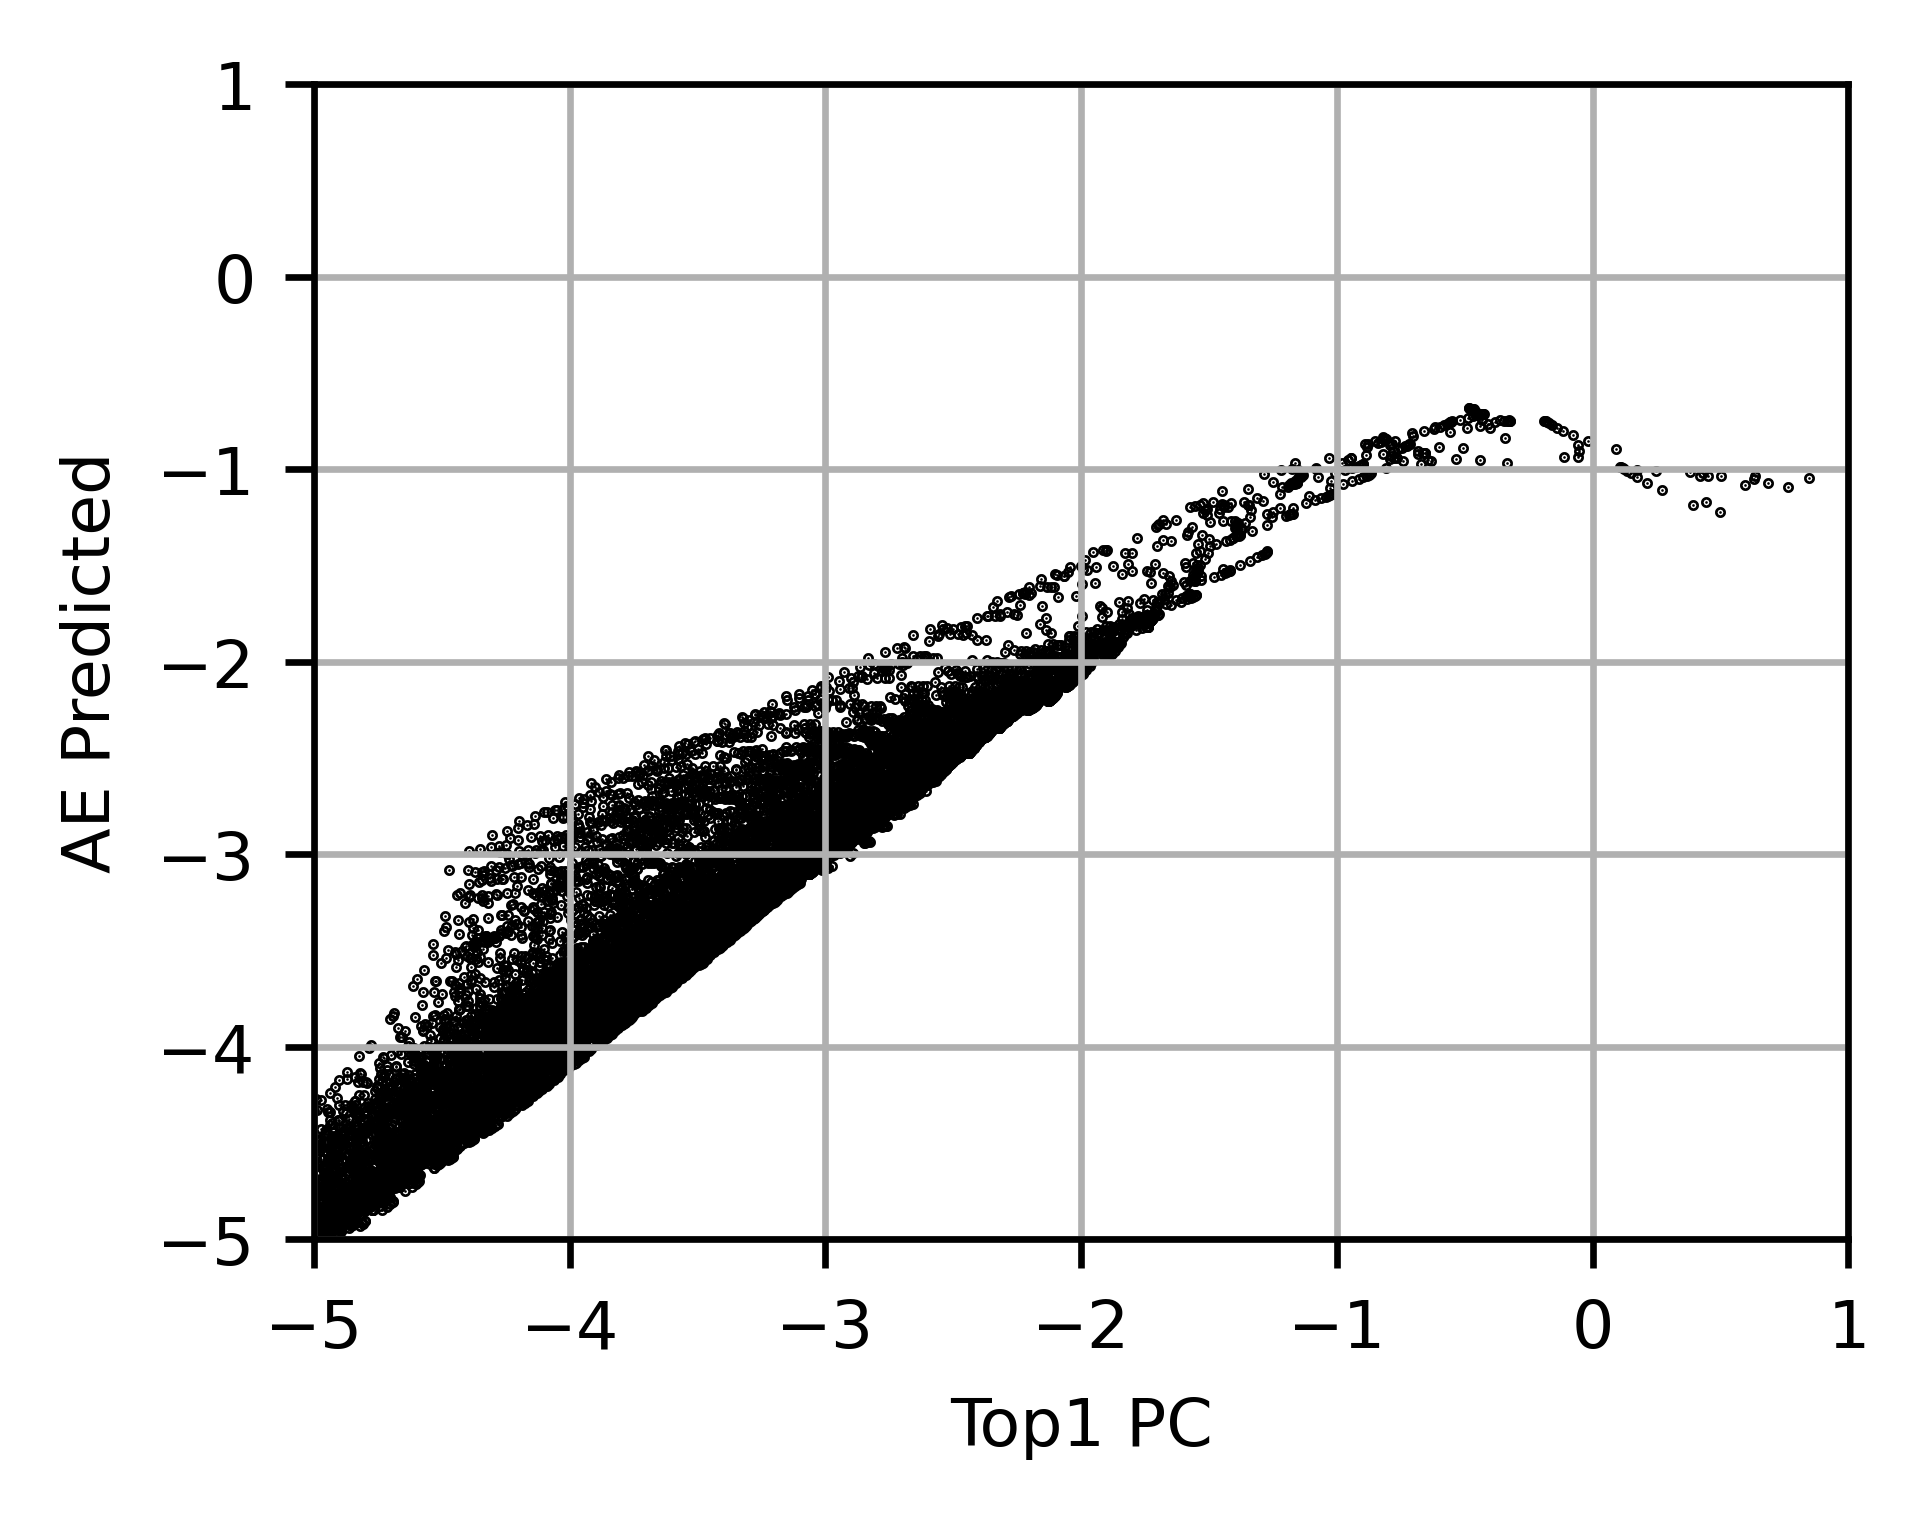

In [93]:
idx=0
plt.scatter(flux32[:, idx],ae_pred32[:, idx], s=0.1)
# plt.plot(   s=0.1, c='k')
plt.xlabel(f"Top{idx+1} PC")
plt.ylabel("AE Predicted")
# plt.legend()
plt.grid(1)
plt.ylim(-5, 1)
plt.xlim(-5, 1)

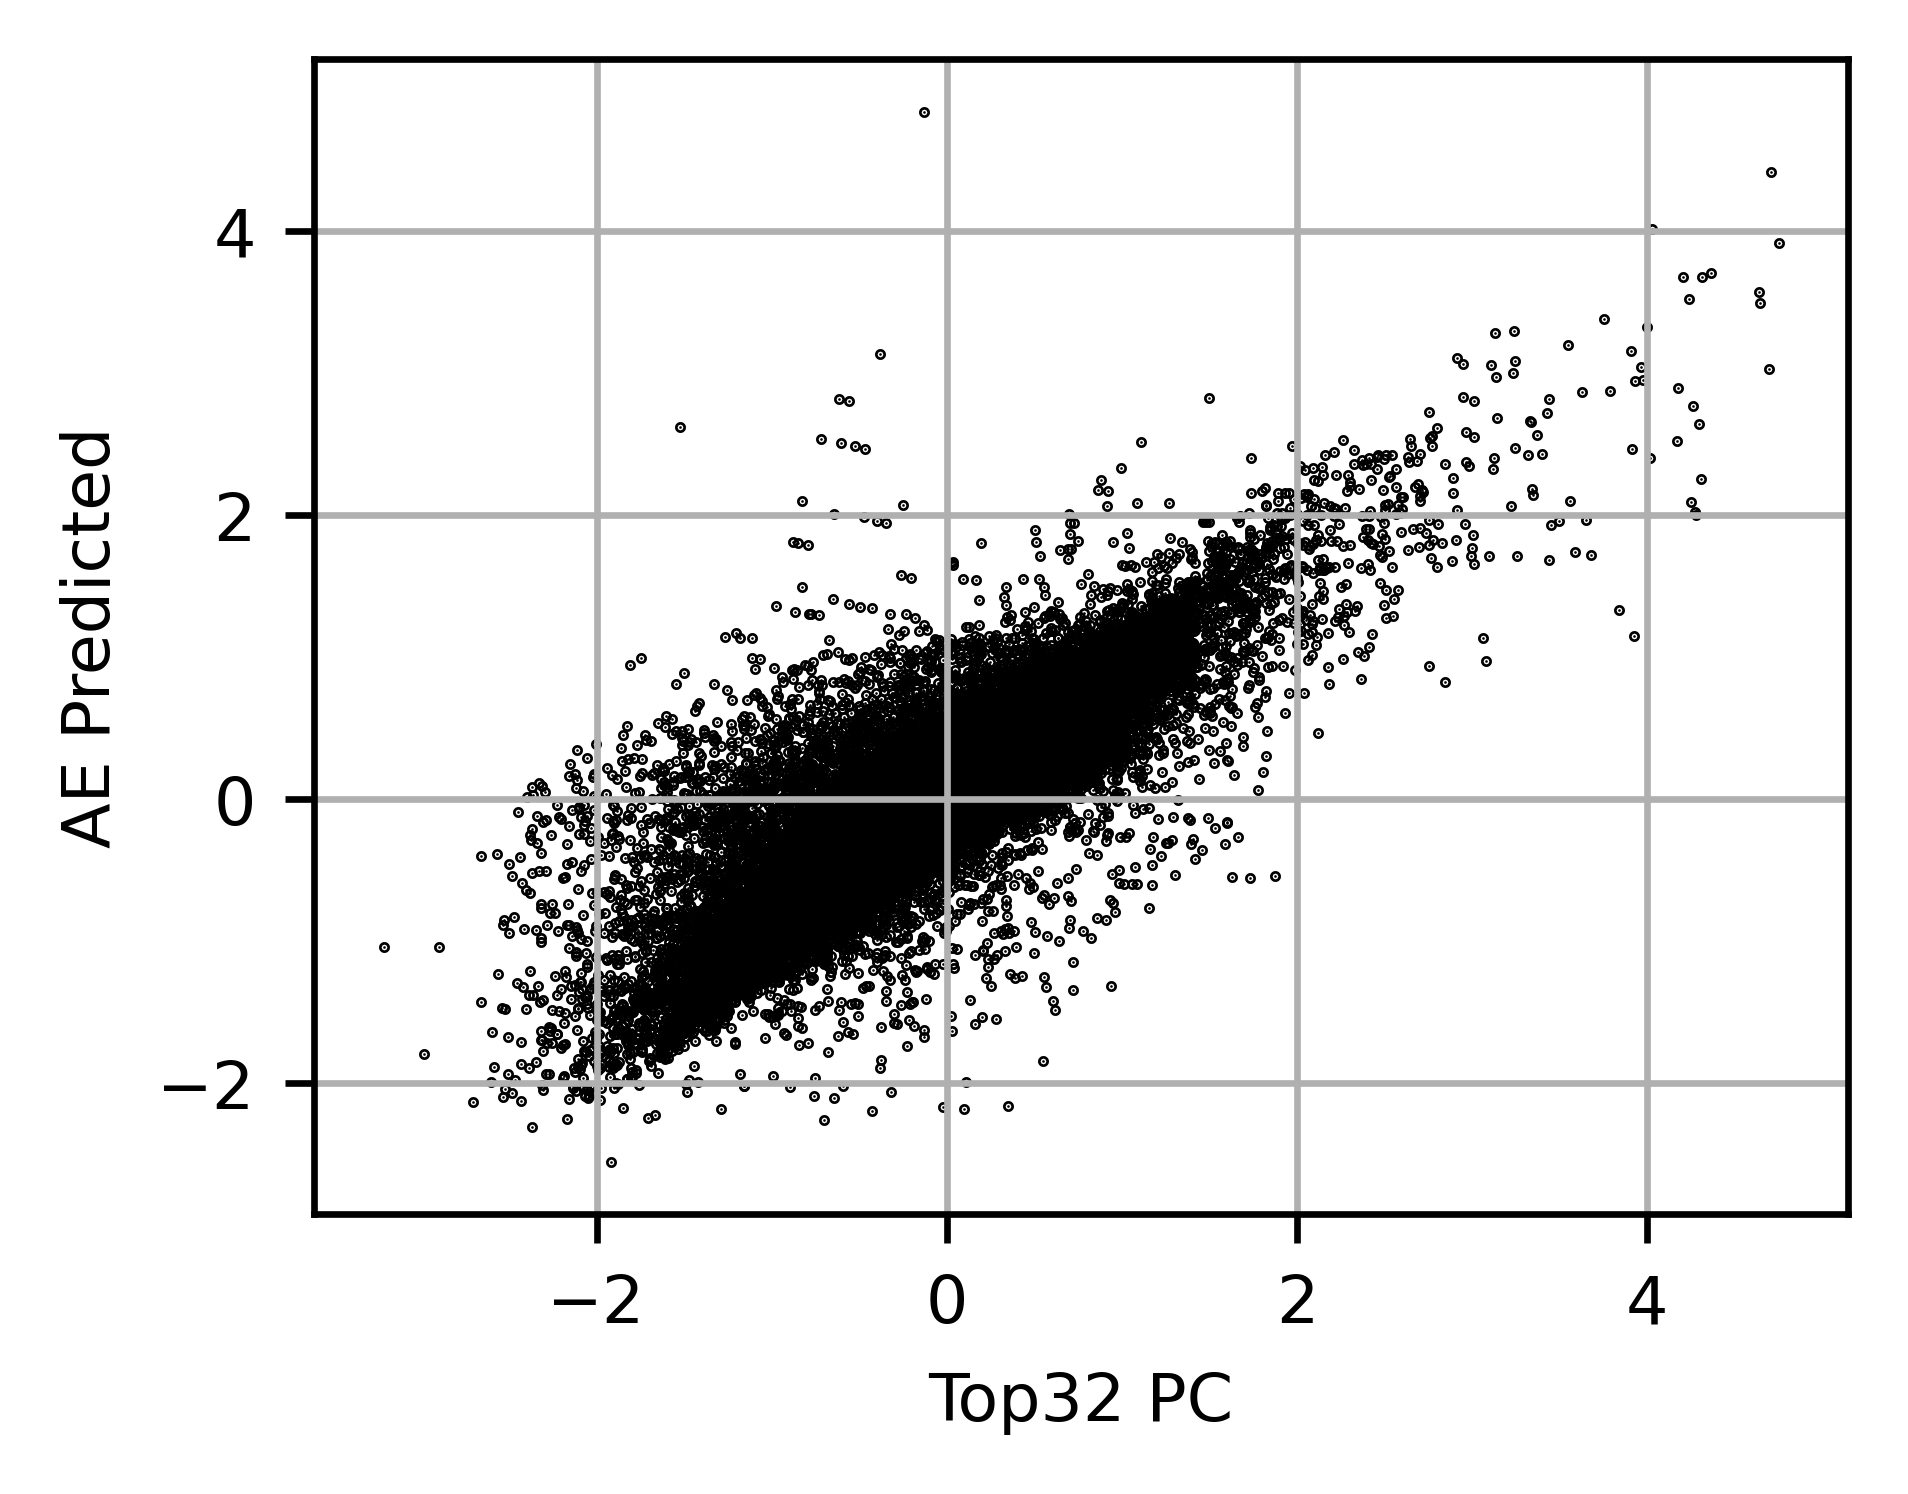

In [85]:
idx=31
plt.scatter(flux32[:, idx],ae_pred32[:, idx], s=0.1)
# plt.plot(   s=0.1, c='k')
plt.xlabel(f"Top{idx+1} PC")
plt.ylabel("AE Predicted")
# plt.legend()
plt.grid(1)

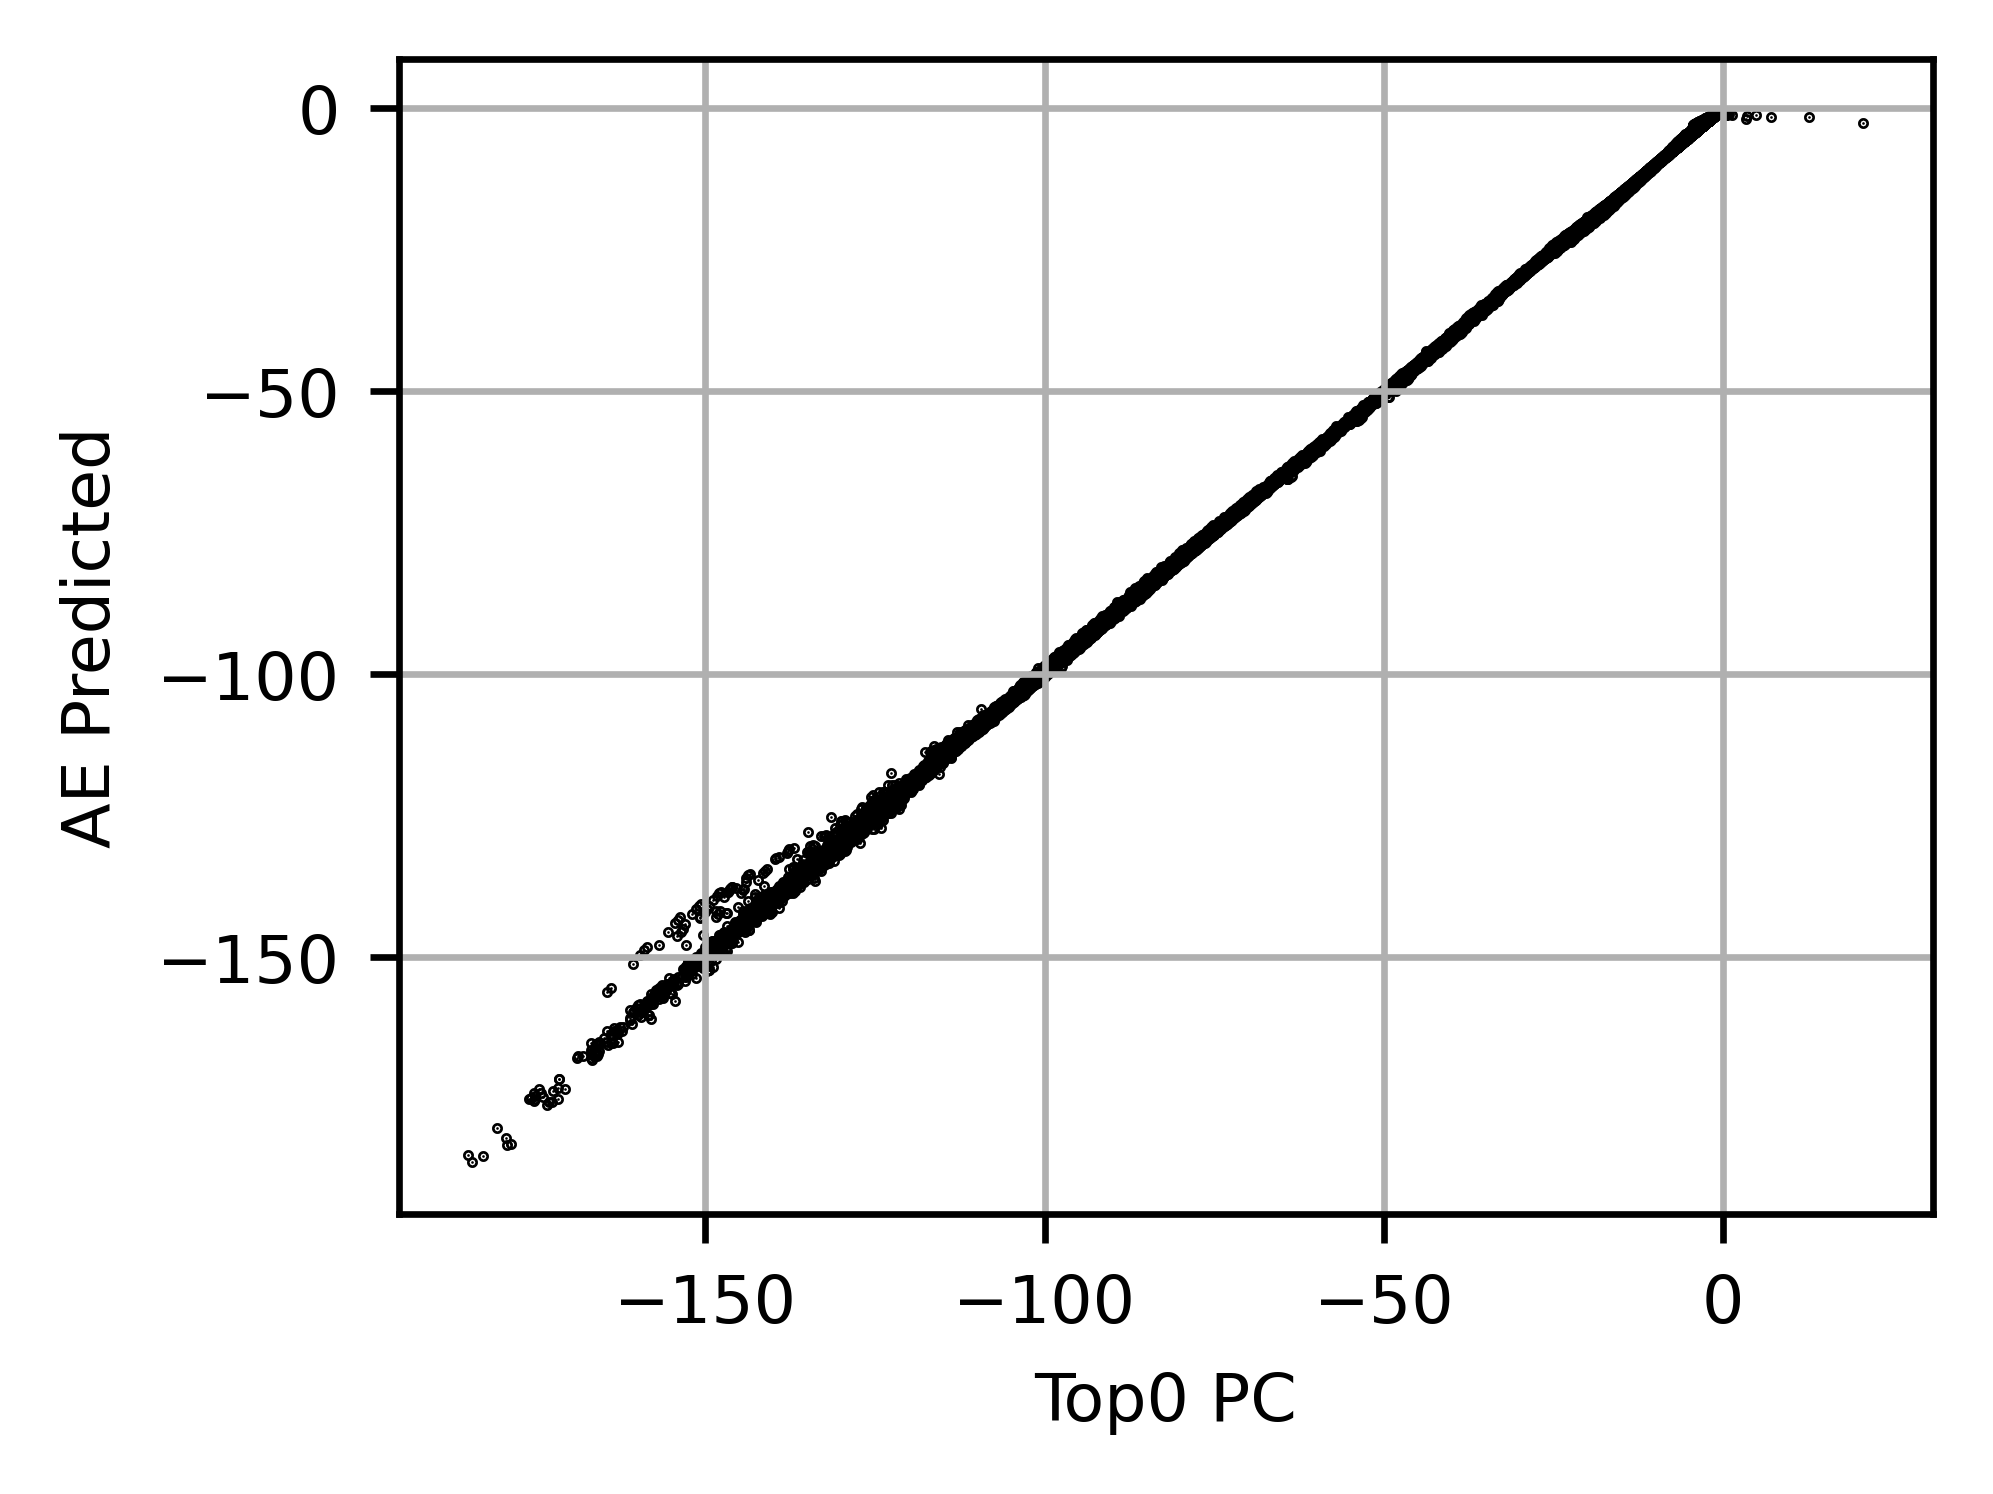

In [82]:
idx=0
plt.scatter(flux32[:, idx],ae_pred32[:, idx], s=0.1)
# plt.plot(   s=0.1, c='k')
plt.xlabel("Top0 PC")
plt.ylabel("AE Predicted")

# plt.legend()
plt.grid(1)

In [ ]:
idx=1
plt.scatter(flux32[:, idx],ae_pred32[:, idx],  s=0.1)
# plt.plot(   s=0.1, c='k')
plt.grid(1)

In [46]:
ae_pred32[0]

array([-3.0604771e+01,  2.1309941e+00, -4.9299364e+00,  2.3654270e-01,
        3.2397854e+00, -3.0641947e+00, -1.2277112e+00,  6.3094243e-02,
       -2.4922962e+00,  7.3537040e-01,  1.3497213e+00, -2.3176761e+00,
       -3.7541524e-02,  1.6302389e+00,  1.8364218e+00,  4.7799164e-01,
       -2.2966228e+00,  8.7250185e-01, -7.3239875e-01,  6.1206269e-01,
        1.8177309e+00, -1.7181134e+00, -1.2966729e+00, -1.4319491e-01,
       -8.0475914e-01, -1.8388782e+00,  2.4185824e-01,  7.1391994e-01,
        8.3485317e-01, -1.7019629e-02, -2.8626305e-01, -4.2166999e-01],
      dtype=float32)

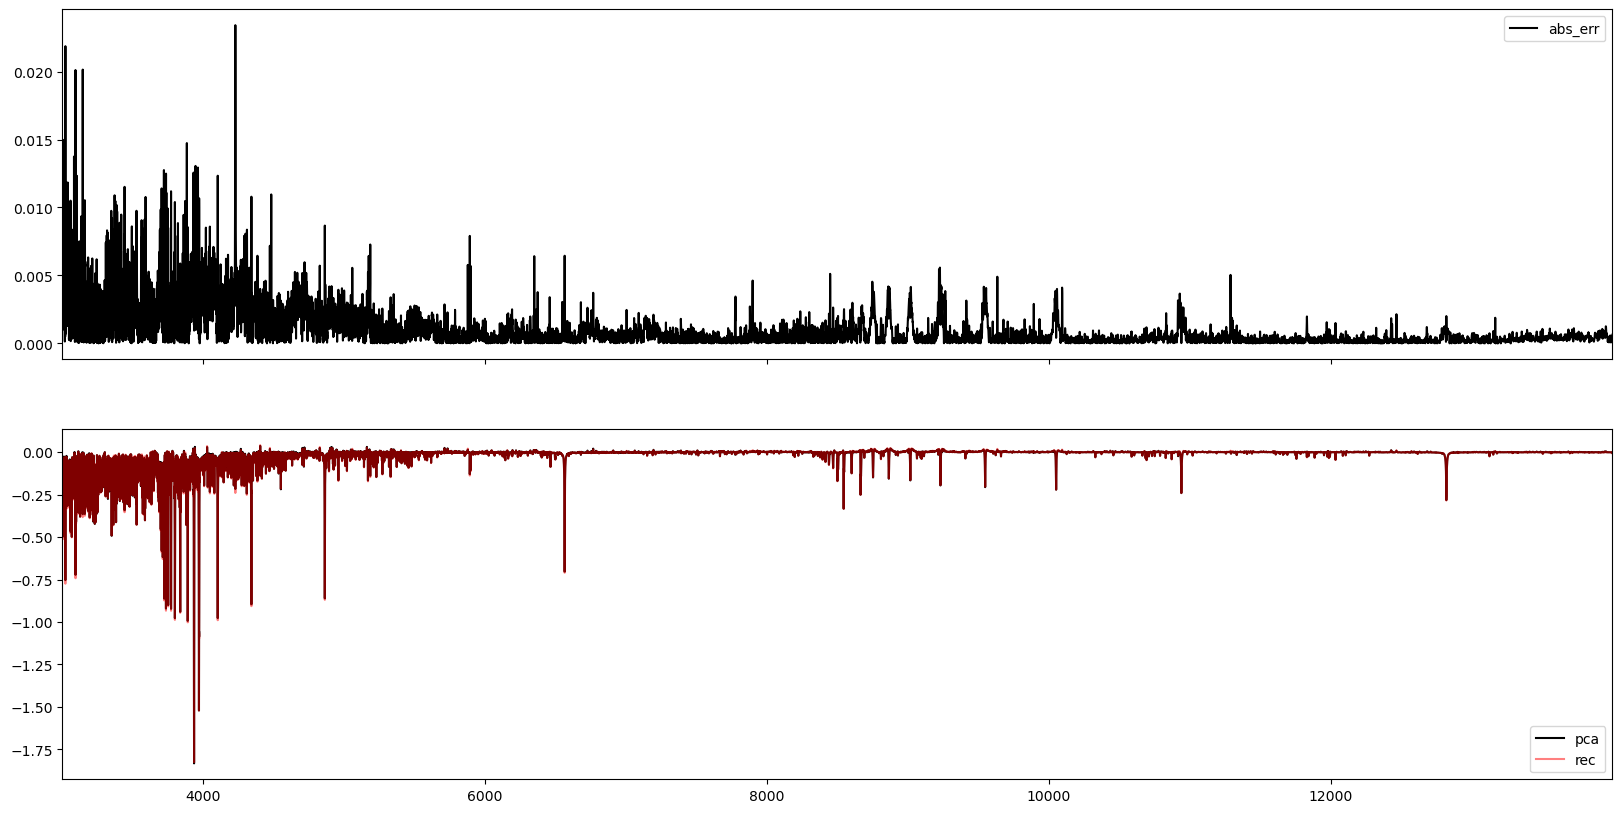

In [45]:
e32.plot_all(10000)

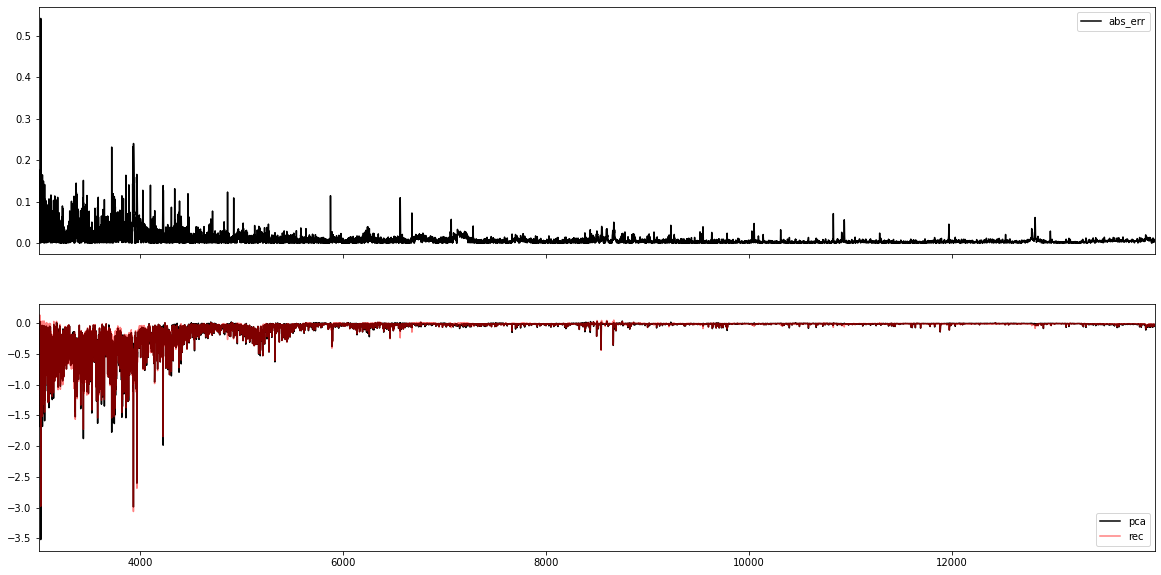

In [839]:
e32.plot_all(0)

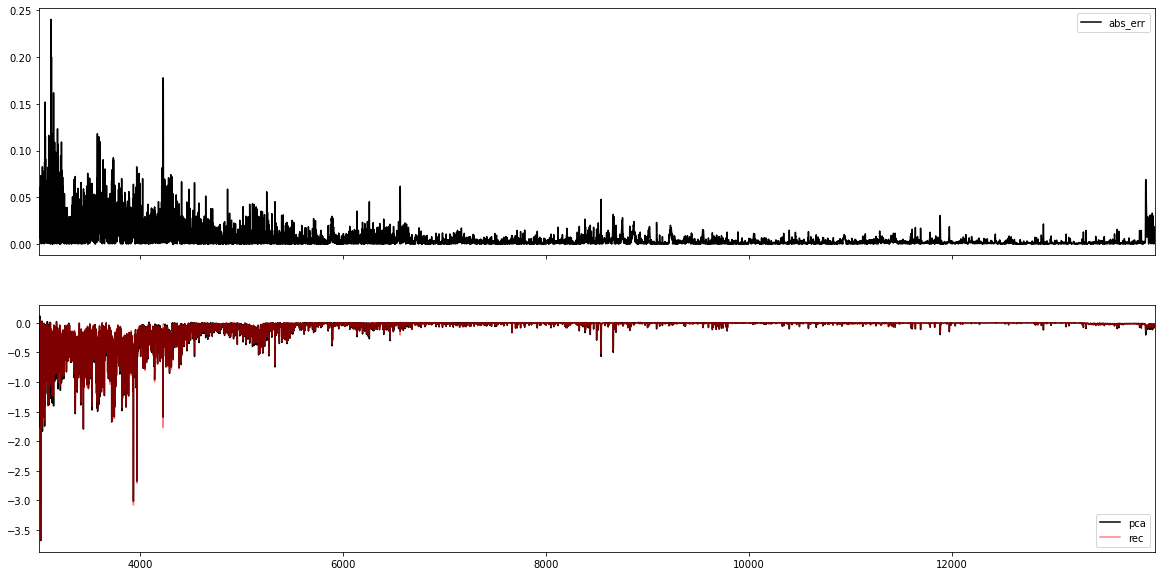

In [824]:
e.plot_all(0)